In this Homework, you will make a Image Captioning Model.

TODO:
1. Tokenize the data and create a vocabulary. And don't forget to add <sos\> and <eos\>.
2. Pad your text data.
3. Split the data into 90:10 train and test set.
4. Create an image encoder (see fig. below)
5. Create an  RNN/LSTM/GRU decoder (see fig. below)
6. Combine both of them for you final image captioning model and train it. The training and generation process will slightly differ. You need to do training using teacher forcing method.
7. Evaluate your model on test set and calculate the [bleu score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).
8. Generate and show captions on any three random images from test set.


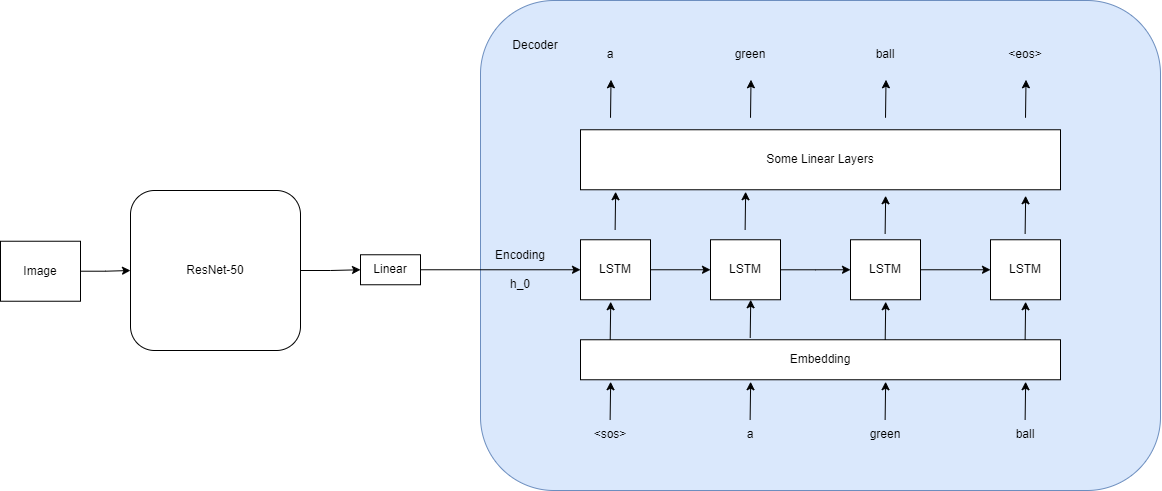

In [1]:
from IPython.display import clear_output, display

In [2]:
# %pip install torch torchvision pillow spacy numpy
# %pip install torchtext
%pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.7 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import math
import random

import numpy as np

import nltk

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoCaptions

from tqdm import tqdm

from PIL import Image
import spacy

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
dataset_variant = 'val2017'

## Downloading the data

In [6]:
# Define paths for dataset and annotations
data_dir = './data'
images_dir = os.path.join(data_dir, dataset_variant)
annotations_dir = os.path.join(data_dir, 'annotations')

# Create directories if they don't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
if not os.path.exists(annotations_dir):
    os.makedirs(annotations_dir)

# Download dataset
!wget http://images.cocodataset.org/zips/{dataset_variant}.zip -P {data_dir}

# Unzip dataset
!unzip {data_dir}/{dataset_variant}.zip -d {data_dir}

clear_output()

In [7]:
# Download annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {annotations_dir}

# # Unzip annotations
!unzip {annotations_dir}/annotations_trainval2017.zip -d {annotations_dir}

clear_output()

## Loading the Dataset

In [8]:
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )

# Load MS-COCO dataset
dataset = CocoCaptions(root=f'./data/{dataset_variant}', annFile=f'./data/annotations/annotations/captions_{dataset_variant}.json', transform=transform)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


## Tokenize

['A woman stands in the dining area at the table.',
 'A room with chairs, a table, and a woman in it.',
 'A woman standing in a kitchen by a window',
 'A person standing at a table in a room.',
 'A living area with a television and a table']

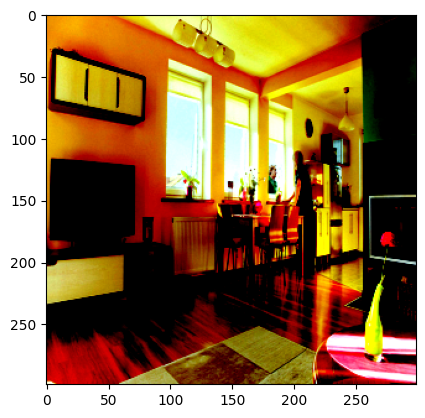

In [9]:
import matplotlib.pyplot as plt

plt.imshow(dataset[0][0].permute(1, 2, 0))
display(dataset[0][1])

In [10]:
from nltk.tokenize import word_tokenize

# Generating vocabulary
class Vocab():
    def __init__(self, data):
        self.data = data
        self.word_to_index = {'<pad>':0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.index_to_word = {it: k for k, it in self.word_to_index.items()}
        self.vocab = set()
        self.generate_vocab()

    def generate_vocab(self):
        for _, captions in tqdm(self.data, desc='Generating Vocab'):
            for text in captions:
                for word in word_tokenize(text.lower()):
                    self.vocab.add(word)
        for idx, word in enumerate(self.vocab):
            self.word_to_index[word] = idx + 4
            self.index_to_word[idx + 4] = word

In [11]:
vocab = Vocab(dataset)

Generating Vocab: 100%|██████████| 5000/5000 [00:38<00:00, 128.82it/s]


## Padding and Splitting Data

In [12]:
max_len = max([len(word_tokenize(caption)) for _, captions in tqdm(dataset) for caption in captions])
print('\nMax length:', max_len)

100%|██████████| 5000/5000 [00:38<00:00, 130.38it/s]


Max length: 54


In [13]:
class CaptioningDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        image, captions = self.data[index]
        caption = np.random.choice(captions)
        caption = word_tokenize(caption.lower())

        if self.transform:
            image = self.transform(image)

        caption.insert(0, '<sos>')
        caption.append('<eos>')

        if len(caption) > max_len:
            caption = caption[:max_len]
        else:
            caption += ['<pad>'] * (max_len - len(caption))

        for i, word in enumerate(caption):
            caption[i] = vocab.word_to_index[word]

        caption = torch.Tensor(caption)
        return image, caption

    def __len__(self):
        return len(self.data)

In [14]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(list(tqdm(dataset)), test_size=0.1, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

100%|██████████| 5000/5000 [00:38<00:00, 129.03it/s]


In [15]:
train_set = CaptioningDataset(train_dataset)
val_set = CaptioningDataset(val_dataset)
test_set = CaptioningDataset(test_dataset)

In [16]:
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
train_set[0][1].shape

torch.Size([54])

In [18]:
train_set[0]

(tensor([[[-1.6898, -1.7412, -1.7069,  ..., -1.6213, -1.6555, -1.6727],
          [-1.7240, -1.6898, -1.7069,  ..., -1.5870, -1.6384, -1.7240],
          [-1.7240, -1.6898, -1.6727,  ..., -1.5185, -1.6042, -1.6555],
          ...,
          [ 1.6324,  1.6324,  1.6324,  ...,  0.9988,  1.0331,  1.0502],
          [ 1.6153,  1.6153,  1.6324,  ...,  1.0502,  1.0844,  1.0844],
          [ 1.6324,  1.6153,  1.6153,  ...,  1.0502,  1.1015,  1.0844]],
 
         [[ 0.0826,  0.1001,  0.0826,  ..., -1.6506, -1.6506, -1.6506],
          [ 0.1001,  0.1001,  0.1001,  ..., -1.6331, -1.6331, -1.6506],
          [ 0.1176,  0.1176,  0.1352,  ..., -1.5280, -1.5980, -1.6155],
          ...,
          [ 1.5007,  1.5182,  1.5357,  ...,  0.9055,  0.9055,  0.9230],
          [ 1.5182,  1.5182,  1.5182,  ...,  0.9055,  0.9055,  0.9405],
          [ 1.5357,  1.4832,  1.4657,  ...,  0.9055,  0.9580,  0.9930]],
 
         [[-0.6367, -0.7064, -0.6193,  ..., -1.4733, -1.4733, -1.4733],
          [-0.7238, -0.7413,

## Image Encoder

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
from torchvision.models import resnet50, ResNet50_Weights

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)

# Only fine tuning
for param in resnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [21]:
resnet.fc = nn.Linear(resnet.fc.in_features, 1024)

## LSTM Decoder

In [22]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim + hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, features):
        batch_size = x.size(0)  # (batch_size, seq_length)
        seq_length = x.size(1)
        
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # Concat x input and encoded features as a skip connection
        features_expanded = features.unsqueeze(1).expand(-1, seq_length, -1)  # (batch_size, seq_length, hidden_dim)
        x = torch.cat((x, features_expanded), dim=2)
        
        self.hidden = features.unsqueeze(0).expand(self.num_layers, batch_size, -1).contiguous()
        self.cell_state = features.unsqueeze(0).expand(self.num_layers, batch_size, -1).contiguous()
        
        x, (self.hidden, self.cell_state) = self.lstm(x, (self.hidden, self.cell_state))
        #  (batch_size, seq_length, hidden_dim)
        
        x = self.dropout(x)
        x = self.fc(x)  # (batch_size, seq_length, output_dim)
        
        return x, self.hidden


In [23]:
vocab_size = len(vocab.word_to_index)

lstm = LSTM(vocab_size, embedding_dim=512, hidden_dim=1024, output_dim=vocab_size, num_layers=4).to(device)
# lstm = nn.DataParallel(lstm, device_ids=[0, 1]).to(device)

### Combining Models

In [24]:
class CaptionGeneration(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, image, captions):
        features = self.encoder(image)
        out, _ = self.decoder(captions, features)
        return out

    def caption(self, images, max_length=50):
        batch_size = images.shape[0]
        device = images.device
        with torch.no_grad():
            features = self.encoder(images)

            start_token = torch.full((batch_size, 1), vocab.word_to_index['<sos>'], dtype=torch.long, device=device)
            generated_answers = start_token

            for _ in range(max_length):
                outputs, _ = self.decoder(generated_answers, features)
                predicted = outputs.argmax(2)[:, -1:]
                generated_answers = torch.cat([generated_answers, predicted], dim=1)

                if (predicted == vocab.word_to_index['<eos>']).all():
                    break

            generated_answers = generated_answers[:, 1:] 
            end_positions = (generated_answers == vocab.word_to_index['<eos>']).float().argmax(1)

            decoded_answers = []
            for i, end_pos in enumerate(end_positions):
                if end_pos == 0:
                    answer = generated_answers[i].tolist()
                else:
                    answer = generated_answers[i, :end_pos].tolist()

                decoded_answer = [vocab.index_to_word[idx] for idx in answer]
                decoded_answers.append(decoded_answer)

        return decoded_answers


In [25]:
model = CaptionGeneration(resnet, lstm).to(device)
model = nn.DataParallel(model, device_ids=[0, 1]).to(device)

## Training

In [26]:
def train(model, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):

        model.train()
        running_training_loss = 0
        running_val_loss = 0

        for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader)):
#             print('Batch', idx)
#             print('image shape', imgs.shape)
#             print('caption shape', captions.shape)
            imgs = imgs.to(device)
            captions = captions.to(device).type(torch.long)

            outputs = model(imgs, captions[:, :-1])
            
#             print('output shape', outputs.shape)
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_training_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for idx, (imgs, captions) in tqdm(enumerate(val_loader), total=len(val_loader)):
                imgs = imgs.to(device)
                captions = captions.to(device).type(torch.long)

                outputs = model(imgs, captions[:, :-1])
                loss = criterion(
                    outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1)
                )

                running_val_loss += loss.item()


        print(f'\nEpoch: {epoch+1}/{num_epochs}', "Training loss: ", running_training_loss/len(train_loader), "Val loss:", running_val_loss/len(val_loader))
        train_losses.append(running_training_loss/len(train_loader))
        val_losses.append(running_val_loss/len(val_loader))

    return train_losses, val_losses

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word_to_index['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
train_losses, val_losses = train(model, criterion, optimizer, num_epochs=10)

100%|██████████| 15/15 [00:02<00:00,  5.51it/s]



Epoch: 1/10 Training loss:  5.229532309404508 Val loss: 4.9623368581136065


100%|██████████| 15/15 [00:02<00:00,  5.47it/s]



Epoch: 2/10 Training loss:  4.928294561040683 Val loss: 4.960828526814779


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]



Epoch: 3/10 Training loss:  4.834993351162888 Val loss: 4.826536623636882


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]



Epoch: 4/10 Training loss:  4.657941232516071 Val loss: 4.429428958892823


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]



Epoch: 5/10 Training loss:  4.381461864381325 Val loss: 4.294700177510579


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]



Epoch: 6/10 Training loss:  4.199662531454732 Val loss: 4.0836479028066


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]



Epoch: 7/10 Training loss:  4.431891003931601 Val loss: 4.292393636703491


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]



Epoch: 8/10 Training loss:  4.511056342462855 Val loss: 4.479448191324869


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]



Epoch: 9/10 Training loss:  4.516322376221184 Val loss: 4.4907931645711265


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch: 10/10 Training loss:  4.367194703244787 Val loss: 4.188501946131388


In [29]:
train_losses_cont, val_losses_cont = train(model, criterion, optimizer, num_epochs=10)
train_losses += train_losses_cont
val_losses += val_losses_cont

100%|██████████| 15/15 [00:02<00:00,  5.24it/s]



Epoch: 1/10 Training loss:  4.1918697094354105 Val loss: 4.111390542984009


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]



Epoch: 2/10 Training loss:  4.048528584908313 Val loss: 4.111447858810425


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]



Epoch: 3/10 Training loss:  3.934469589098232 Val loss: 3.913302532831828


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]



Epoch: 4/10 Training loss:  3.879615928244403 Val loss: 3.887966823577881


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]



Epoch: 5/10 Training loss:  3.7457005714806986 Val loss: 3.78178079922994


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]



Epoch: 6/10 Training loss:  3.704731402434702 Val loss: 3.63356196085612


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]



Epoch: 7/10 Training loss:  3.684921750872154 Val loss: 3.7783478260040284


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]



Epoch: 8/10 Training loss:  3.616079503157007 Val loss: 3.6542755762736


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 9/10 Training loss:  3.5657130996073323 Val loss: 3.671235783894857


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch: 10/10 Training loss:  3.5293345582766795 Val loss: 3.5829388936360678


In [35]:
train_losses_cont, val_losses_cont = train(model, criterion, optimizer, num_epochs=15)
train_losses += train_losses_cont
val_losses += val_losses_cont

100%|██████████| 15/15 [00:02<00:00,  5.26it/s]



Epoch: 1/15 Training loss:  3.504580000254113 Val loss: 3.5932257652282713


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]



Epoch: 2/15 Training loss:  3.43649386045501 Val loss: 3.619201342264811


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 3/15 Training loss:  3.4357221708523005 Val loss: 3.5642143726348876


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]



Epoch: 4/15 Training loss:  3.3905896520990084 Val loss: 3.631227890650431


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 5/15 Training loss:  3.3727066404237522 Val loss: 3.6739268779754637


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]



Epoch: 6/15 Training loss:  3.3205370302275408 Val loss: 3.5320637385050455


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]



Epoch: 7/15 Training loss:  3.2877911826756994 Val loss: 3.534123690923055


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 8/15 Training loss:  3.3116256289594754 Val loss: 3.511528476079305


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 9/15 Training loss:  3.2451652879790056 Val loss: 3.447376028696696


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]



Epoch: 10/15 Training loss:  3.2798455362244856 Val loss: 3.4886736392974855


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]



Epoch: 11/15 Training loss:  3.241579436880397 Val loss: 3.598355595270793


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]



Epoch: 12/15 Training loss:  3.1796900794262024 Val loss: 3.612567965189616


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]



Epoch: 13/15 Training loss:  3.1737843404604695 Val loss: 3.4309130668640138


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]



Epoch: 14/15 Training loss:  3.105693146938414 Val loss: 3.317429955800374


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch: 15/15 Training loss:  3.0894520770846388 Val loss: 3.5100424607594807


In [42]:
train_losses_cont, val_losses_cont = train(model, criterion, optimizer, num_epochs=15)
train_losses += train_losses_cont
val_losses += val_losses_cont

100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 1/15 Training loss:  3.0856699962315597 Val loss: 3.56780842145284


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]



Epoch: 2/15 Training loss:  3.06388192852651 Val loss: 3.442488733927409


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]



Epoch: 3/15 Training loss:  3.038817409455307 Val loss: 3.4117600282033282


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 4/15 Training loss:  2.9906786163960857 Val loss: 3.3676589012145994


100%|██████████| 15/15 [00:03<00:00,  4.85it/s]



Epoch: 5/15 Training loss:  2.984665609720185 Val loss: 3.5140194098154702


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]



Epoch: 6/15 Training loss:  2.995489914586225 Val loss: 3.47411683400472


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]



Epoch: 7/15 Training loss:  2.9685644333756813 Val loss: 3.4334163029988605


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]



Epoch: 8/15 Training loss:  2.949777745825099 Val loss: 3.4219806671142576


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]



Epoch: 9/15 Training loss:  2.916431813728152 Val loss: 3.435899003346761


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]



Epoch: 10/15 Training loss:  2.9070777836747057 Val loss: 3.4336928526560464


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 11/15 Training loss:  2.9053283188286727 Val loss: 3.4969276905059816


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]



Epoch: 12/15 Training loss:  2.895033853260551 Val loss: 3.33102597395579


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]



Epoch: 13/15 Training loss:  2.8550016391934374 Val loss: 3.4742098172505695


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]



Epoch: 14/15 Training loss:  2.8426878865309586 Val loss: 3.424486684799194


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch: 15/15 Training loss:  2.8283500314697507 Val loss: 3.6724002361297607


In [30]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(['Train', 'Validation'])
    plt.show()

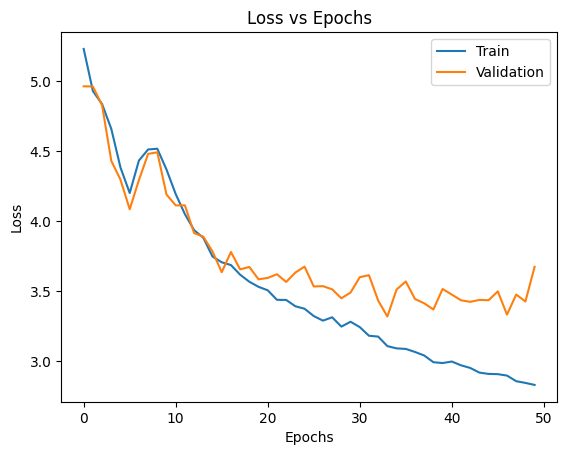

In [43]:
plot_losses(train_losses, val_losses)

## BLEU Score

In [44]:
from nltk.translate.bleu_score import corpus_bleu

class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img, captions = self.data[index]
        tokenized = [word_tokenize(caption.lower()) for caption in captions]
        return img, tokenized

def collate_fn(data):
    images, captions = zip(*data)
    return torch.stack(images), list(captions)

test_loader = DataLoader(TestDataset(test_dataset), batch_size=64, collate_fn=collate_fn)

generated_captions = []
reference_captions = []

model.eval()
with torch.no_grad():
    for img, ref_captions in tqdm(test_loader):
#         print('ref: ', ref_captions)
        img = img.to(device)
        
        captions = model.module.caption(img)
#         print('gen: ', generated_captions)
        
        generated_captions += captions              
        reference_captions += ref_captions

bleu_score = corpus_bleu(reference_captions, generated_captions)
print("BLEU Score:", bleu_score)


100%|██████████| 8/8 [00:20<00:00,  2.58s/it]

BLEU Score: 0.18550259886734993


In [45]:
test_loader = DataLoader(TestDataset(train_dataset), batch_size=64, collate_fn=collate_fn)

generated_captions = []
reference_captions = []

model.eval()
with torch.no_grad():
    for img, ref_captions in tqdm(test_loader):
#         print('ref: ', ref_captions)
        img = img.to(device)
        
        captions = model.module.caption(img)
#         print('gen: ', generated_captions)
        
        generated_captions += captions              
        reference_captions += ref_captions

bleu_score = corpus_bleu(reference_captions, generated_captions)
print("BLEU Score (Training):", bleu_score)

100%|██████████| 64/64 [02:43<00:00,  2.55s/it]


BLEU Score (Training): 0.2127468167094277


## Generate Captions

Label: ['A woman is about to throw a frisbee in the dirt.', 'A woman is playing frisbee at a camp site.', 'A woman playing Frisbee on a tent city road', 'There is a green Frisbee in the air with red chairs in the background.', 'A man holding a neon frisbee in his right hand.']

Predicted Caption: a man is is standing on the side of a road .


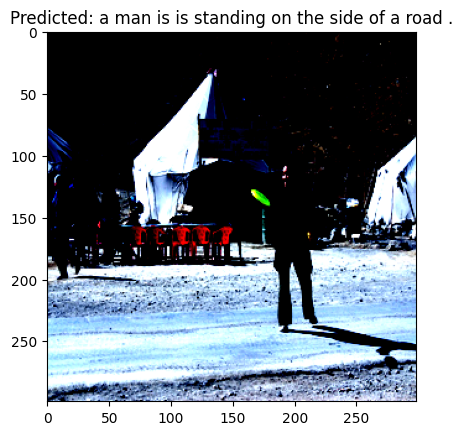

---------------------------------------------------------------------------------------------------- 

Label: ['A group of people sitting under umbrellas drinking beer.', 'Groups of people seated under shade umbrellas at blue tables and chairs drinking beverages.', 'A shady spot for cold drinks, including beer in glass bottles.', 'Blue tables sit under blue umbrellas and people sit around the tables.', 'many people sitting at different tables under a tent']

Predicted Caption: a group of people are are sitting at a market .


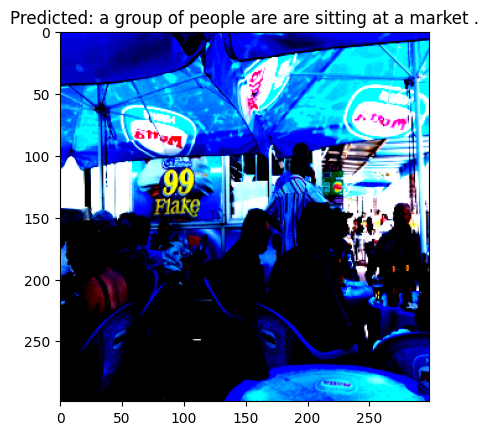

---------------------------------------------------------------------------------------------------- 

Label: ['A woman sitting on a wooden bench on a wall.', 'A woman is sitting on an old wooden bench.', 'This woman is sitting on a bench and looking in the right direction.', 'A woman in grey shirt and hat sitting on a wooden bench.', 'A woman sitting on a wooden bench next to a rock wall.']

Predicted Caption: a woman sitting on a bench with a forest .


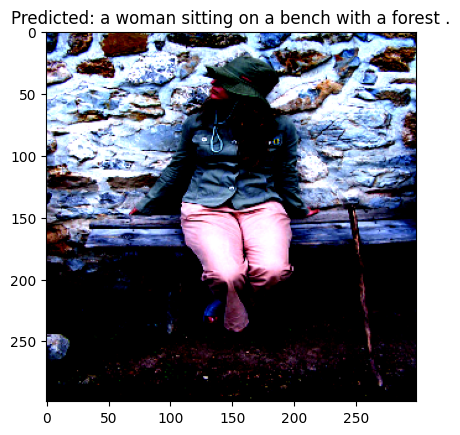

---------------------------------------------------------------------------------------------------- 



In [46]:
for _ in range(3):
    i = np.random.randint(len(test_dataset))
    data = test_dataset[i]
    
    img, label = data
    print("Label:", label)
    
    input = img.to(device).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        caption = model.module.caption(input)
    
    print("\nPredicted Caption:", " ".join(caption[0]))
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title('Predicted: ' + ' '.join(caption[0]))
    plt.show()
    print("-"*100,"\n")